In [ ]:
# Imports for loading and preprocessing the data
import random
import numpy as np
import pandas as pd
from tqdm import tqdm  # show progress bar
from nltk.tokenize import TweetTokenizer

# TensorFlow 
import tensorflow as tf
# Next line only for Colab
# %tensorflow_version 2.x

# Sklearn for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Bokeh for visualization
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Title
from bokeh.transform import factor_cmap
from bokeh.palettes import Colorblind3

In [ ]:
# dataset coming from 1_Preprocessing
tweets = pd.read_pickle("path/New_Preprocessed_Dataset_GAN.pkl")
tweets = tweets[tweets['label'] == 'sexism']

In [3]:
# dataframe to list of sentences
sentences = tweets['text'].tolist()
print(sentences[:5])

['call me sexist but when i go to an auto place id rather talk to a guy', 'nooo not sexist but most women are bad drivers', 'there is something wrong when a girl wins wayne rooney street striker', 'literally on this site today', 'according to holly from geordie shore sassy halfway between slut and classy']


In [ ]:
# Apply nltk tweettokenizer
tweets_tokenized = [TweetTokenizer(preserve_case=False).tokenize(tweet) for tweet in sentences]

In [ ]:
from gensim.models import KeyedVectors
from collections import defaultdict

# 1. load full GloVe
glove_path = "path/glove.6B.200d.txt"
glove = KeyedVectors.load_word2vec_format(glove_path, no_header=True)

# 2. detect singletons
word_counts = defaultdict(int)
for tweet in tweets_tokenized:
    for word in tweet:
        word_counts[word] += 1

singletons = {word for word, count in word_counts.items() if count == 1}

# 3. check if singletons are in GloVe
missing_singletons = {word for word in singletons if word not in glove}

# 4. filter tweets to remove those containing missing singletons
filtered_tweets = [
    tweet for tweet in tweets_tokenized
    if not any(word in missing_singletons for word in tweet)
]

print(f"Phrases initiales: {len(tweets_tokenized)}")
print(f"Phrases filtrées: {len(filtered_tweets)}")
print(f"Phrases supprimées: {len(tweets_tokenized) - len(filtered_tweets)}")
print(f"Singletons problématiques: {len(missing_singletons)}")

Phrases initiales: 3258
Phrases filtrées: 2868
Phrases supprimées: 390
Singletons problématiques: 449


In [6]:
tweets_tokenized = filtered_tweets

In [7]:
# Set a seed to make results comparable
random.seed(69)
# Shuffle the dataset once, to obtain random train and test partitions later
random.shuffle(tweets_tokenized)

# Add start and end of sequence token to every tweet
# and create the two datasets
train_data = []
word2vec_data = []

for tweet in tweets_tokenized:
  tweet.insert(len(tweet), "<End>")
  tweet.insert(0, "<Start>")
  train_data.append((tweet, tweet[1:], tweet[:-1]))
  word2vec_data.append(tweet)

In [8]:
max_length = 0
idx = 0
for tweet in tweets_tokenized:
  if len(tweet) > max_length:
    max_length = len(tweet)

print(f"Longest Tweet has {max_length} tokens.")

Longest Tweet has 38 tokens.


In [9]:
all_tokens = set(token for tweet in tweets_tokenized for token in tweet)

In [ ]:
def load_glove_subset(glove_file_path, allowed_tokens):
    glove_model = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            if word in allowed_tokens:
                embedding = np.array(split_line[1:], dtype=np.float64)
                glove_model[word] = embedding
    return glove_model

glove_subset = load_glove_subset("path/glove.6B.200d.txt", all_tokens)

In [ ]:
# initialize a KeyedVectors model with the correct vector size
model = KeyedVectors(vector_size=200)

# add the loaded GloVe vectors to the model
for token, vector in glove_subset.items():
    model.add_vector(token, vector)

print(f"Vocab size of our glove model : {len(model.key_to_index)} / total vocab : {len(all_tokens)}")

# list to keep track of missing tokens
missing_tokens = []

# Add missing tokens with random vectors (such as the <Start>, <End>, and <user> tokens)
for tweet in tweets_tokenized:
    for token in tweet:
        if token not in model.key_to_index:
            model.add_vector(token, np.random.normal(scale=0.6, size=(model.vector_size,)))
            missing_tokens.append(token)

# display missing tokens
print(f"\n{len(missing_tokens)} missing tokens added with random vectors:\n")
print(sorted(set(missing_tokens)))

In [12]:
embedding_matrix = np.zeros((len(model.key_to_index), 200))
for i in range(len(model.key_to_index)):
    embedding_vector = model[model.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Add a single row to shift the matrix to the right (since later we use 0 padding for our batches)
embedding_matrix = np.insert(arr=embedding_matrix, obj=0, values=np.zeros(200), axis=0)

embedding_matrix.shape

(5028, 200)

In [13]:
vocab_size = len(model.key_to_index)
print(f"Vocab size of our word2vec model: {vocab_size}")

Vocab size of our word2vec model: 5027


In [ ]:
# create a word2index dictionary and an embedding matrix
word2index_dict = {}
embedding_matrix = [np.zeros(200)]

for i, token in enumerate(model.key_to_index):
    word2index_dict[token] = i + 1               # +1 because 0 = padding
    embedding_matrix.append(model[token])

embedding_matrix = np.array(embedding_matrix)

tweets2index_input = []
tweets2index_target = []
tweets2index_teacher_forcing = []

for input_seq, target_seq, teacher_seq in train_data:
    input = [word2index_dict[key] for key in input_seq]
    target = [word2index_dict[key] for key in target_seq]
    teacher = [word2index_dict[key] for key in teacher_seq]

    tweets2index_input.append(input)
    tweets2index_target.append(target)
    tweets2index_teacher_forcing.append(teacher)

In [15]:
print(tweets2index_input[0])
print(tweets2index_teacher_forcing[0])
print(tweets2index_target[0])

[5023, 35, 655, 30, 4143, 28, 35, 655, 447, 2615, 35, 655, 8, 1120, 2940, 57, 2504, 5024]
[5023, 35, 655, 30, 4143, 28, 35, 655, 447, 2615, 35, 655, 8, 1120, 2940, 57, 2504]
[35, 655, 30, 4143, 28, 35, 655, 447, 2615, 35, 655, 8, 1120, 2940, 57, 2504, 5024]


In [ ]:
train_split = 0.9  # 90 train / 10 test was best for our model

batch_size = 16

train_size = int(len(tweets2index_input) * train_split)

# training data
train_ragged_dataset_input = tf.ragged.constant(tweets2index_input[:train_size])
train_ragged_dataset_target = tf.ragged.constant(tweets2index_target[:train_size])
train_ragged_dataset_teacher = tf.ragged.constant(tweets2index_teacher_forcing[:train_size])

train_dataset_input = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_input)
train_dataset_target = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_target)
train_dataset_teacher = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_teacher)

train_dataset_input = train_dataset_input.map(lambda x: x)
train_dataset_target = train_dataset_target.map(lambda x: x)
train_dataset_teacher = train_dataset_teacher.map(lambda x: x)

# training dataset
train_dataset = tf.data.Dataset.zip((train_dataset_input, train_dataset_target, train_dataset_teacher))

train_dataset = (train_dataset
                .cache()
                .shuffle(buffer_size=10000, reshuffle_each_iteration=True) 
                .padded_batch(batch_size) 
                .prefetch(tf.data.experimental.AUTOTUNE))

# test data
test_ragged_dataset_input = tf.ragged.constant(tweets2index_input[train_size:])
test_ragged_dataset_target = tf.ragged.constant(tweets2index_target[train_size:])
test_ragged_dataset_teacher = tf.ragged.constant(tweets2index_teacher_forcing[train_size:])

test_dataset_input = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_input)
test_dataset_target = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_target)
test_dataset_teacher = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_teacher)

test_dataset_input = test_dataset_input.map(lambda x: x)
test_dataset_target = test_dataset_target.map(lambda x: x)
test_dataset_teacher = test_dataset_teacher.map(lambda x: x)

# test dataset
test_dataset = (tf.data.Dataset.zip((test_dataset_input, test_dataset_target, test_dataset_teacher))
                .cache()
                .padded_batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
import sys
sys.path.append('path/Modules/sexism')

import sexism_ae as ae
import sexism_ae_training as ae_training

In [18]:
TwitterAE = ae.AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix)

In [ ]:
# train the model

ae_training.trainModel(model=TwitterAE, word2vec_model=model, train_dataset=train_dataset, test_dataset=test_dataset, loss_function=tf.keras.losses.SparseCategoricalCrossentropy(), num_epochs=100, early_stopping_patience=50, lr_reduce_factor=0.9)

In [ ]:
# if you want to load weights from a previous training

sequence_length = 200
dummy_input = np.random.randint(0, vocab_size, (1, sequence_length))
dummy_teacher = np.random.randint(0, vocab_size, (1, sequence_length))

# Dummy pass to build the model (initialize weights)
_ = TwitterAE(dummy_input, dummy_teacher, training=False)

In [ ]:
TwitterAE.load_weights("path/AE_Weights/sexism_ae_weights.weights.h5")

In [21]:
TwitterAE.summary()

Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │     1,186,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     5,949,828 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,136,628 (27.22 MB)

 Trainable params: 5,125,428 (19.55 MB)

 Non-trainable params: 2,011,200 (7.67 MB)

### Gan

In [22]:
train_dataset_GAN = train_dataset_input
train_dataset_GAN = train_dataset_input.map(lambda x: tf.squeeze(TwitterAE.Encoder(tf.expand_dims(x, axis=0)), axis=0))
train_dataset_GAN = train_dataset_GAN.cache().batch(50).prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
import sexism_latextgan as latextgan
import sexism_latextgan_training as latextgan_training

In [ ]:
# Initialize your models
LaTextGAN_Generator = latextgan.Generator() 
LaTextGAN_Discriminator = latextgan.Discriminator()


From Fixed Vector: the only thing that is churning is refined and that is a non of those of work <End>
From Fixed Vector: so boring and you are a feminist ? <user> i am not sexist but women should not be allowed . <End>

From Random Vector: mkr the sassy girls are better at at least . <End>
From Random Vector: the hadith are going to tell . <user> i am not sexist but i have never met a woman president . <End>


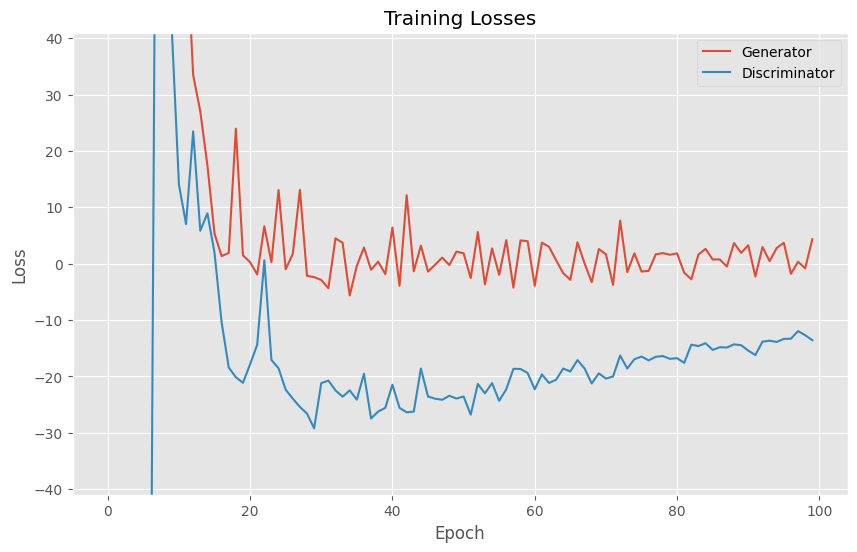

Time: 2.22s


In [ ]:
# Create the trainer instance
trainer = latextgan_training.GANTrainer(
    generator=LaTextGAN_Generator,
    discriminator=LaTextGAN_Discriminator,
    autoencoder=TwitterAE,
    word2vec_model=model
)

# Train the model
trainer.train(
    dataset=train_dataset_GAN,
    epochs=100, 
    lr=0.0001,  # Learning rate 
    d_steps=5  # Number of discriminator steps per generator step
)

In [25]:
import sexism_latextgan_evaluation as eval

Loading BokehJS ...

In [27]:
eval.tweet_generator(generator=LaTextGAN_Generator, autoencoder=TwitterAE, word2vec_model=model, num_tweets=50)


the face of the blonde molls screwed on not that is not that is defined cunts ! <End>

mkr <name> is better tv . she is a natural villian unlike ash who is a fake on one ? <End>

mkr <name> is better delusional . she is a desperate at the relationship <End>

the only thing that is churning the blondes is not real blondes . it is wrong <End>

convinced that <name> is satan <End>

this is the trick of the promo girls ? <user> i am not sexist but a girl should never be in the infantry in a relationship . <End>

mkr annies never cooked never mind a woman is a good job of humiliating herself . <End>

if i hear that men who talk about about football that women do not know how they do <End>

questions for men do you think that scientists are the same of women that men are superior to block them somehow . <End>

the missus loves will not be a woman in the street . i am not sexist but the last is a female captain <End>

if you are a feminist ? do not know what . <user> call me sexist but femal

In [28]:
eval.bleu4_score(generator=LaTextGAN_Generator, autoencoder=TwitterAE, word2vec_model=model, reference_data=train_data, num_tweets=500)

0.6925588452223765

In [ ]:
#LaTextGAN_Generator.save_weights(f"path/GAN_Weights/sexism_LaTextGAN.weights.h5")

In [ ]:
latent_dim = 100
# dummy input for the generator to build the model
dummy_input = tf.random.normal((1, latent_dim))
_ = LaTextGAN_Generator(dummy_input, training=False)

# load weights
LaTextGAN_Generator.load_weights("path/GAN_Weights/sexism_LaTextGAN.weights.h5")

In [27]:
eval.tweet_generator(generator=LaTextGAN_Generator, autoencoder=TwitterAE, word2vec_model=model, num_tweets=5)


no clue is a feminist . do not know a good . <End>

mkr everyone under estimated us umm you you know that is the same is not a good person ? huh ? <End>

the democratic peoples republic of korea must be a wonderful place that sexist . look like ! <End>

i have never had a dollar for for women today because they do not think how women should not be allowed <End>

so you are a moderator <user> i am not sexist but women should not be allowed to be commentators for football games . <End>


Average length of generated tweets: 19.8 tokens



In [ ]:
def tweet_generator(generator, autoencoder, model, target_num: int = 1500, label: str = None, oversampling_factor: int = 10):
    """
    Generate a target number of unique synthetic tweets using a GAN and Autoencoder.

    Args:
        generator (tf.keras.Model): The trained generator model.
        autoencoder (object): Autoencoder with a Decoder.inference_mode method.
        model (gensim KeyedVectors): Pretrained word2vec model (for index_to_key).
        target_num (int): Number of unique tweets to generate.
        label (str, optional): Label to assign to the generated tweets.
        oversampling_factor (int): How much to oversample at each iteration to reach uniqueness.

    Returns:
        pd.DataFrame: DataFrame with columns ['text'] or ['text', 'label'].
    """
    unique_tweets = set()
    total_tokens = 0

    pbar = tqdm(total=target_num, desc="Collecting unique tweets")

    while len(unique_tweets) < target_num:
        num_to_generate = (target_num - len(unique_tweets)) * oversampling_factor
        noise = tf.random.normal([num_to_generate, 100])
        fake_states = generator(noise)

        for i in range(num_to_generate):
            decoded_indices = autoencoder.Decoder.inference_mode(states=tf.expand_dims(fake_states[i], 0), training=False)
            tokens = [model.index_to_key[i.numpy()[0] - 1] for i in decoded_indices if i.numpy()[0] != 0]
            tweet = ' '.join(tokens)
            if tweet not in unique_tweets:
                unique_tweets.add(tweet)
                total_tokens += len(tokens)
                pbar.update(1)
                if len(unique_tweets) == target_num:
                    break

    pbar.close()
    df = pd.DataFrame({'text': list(unique_tweets)})
    if label:
        df['label'] = label

    avg_len = total_tokens / target_num
    print(f"Generated {target_num} unique tweets. Average length: {avg_len:.2f} tokens.")

    return df

In [29]:
synthetic_df = tweet_generator(generator=LaTextGAN_Generator, autoencoder=TwitterAE, model=model, target_num=5000)

Generated 5000 unique tweets. Average length: 19.09 tokens.


In [ ]:
synthetic_df.to_pickle("path/Dataset/sexism_gan_tweets.pkl")

In [31]:
# print unique len of synthetic_df
print(f"Unique tweets in synthetic_df: {len(synthetic_df['text'].unique())}")

Unique tweets in synthetic_df: 5000


In [30]:
def plot_tsne_only(generator, autoencoder, train_dataset: tf.data.Dataset, name: str):
    """Plot 2D TSNE Embedding of Generator vs Encoder (no extra print)."""

    # Encode real tweets (Encoder)
    real_embeddings = [autoencoder.Encoder(tweet, training=False) for tweet, _, _ in train_dataset.take(500)]
    real_embeddings = [vec.numpy() for batch in real_embeddings for vec in batch]

    # Generate fake tweets (Generator)
    fake_embeddings = []
    for _ in range(500):
        noise = tf.random.normal([50, 100])
        fake_batch = generator(noise)
        fake_embeddings.extend(fake_batch.numpy())

    # Apply PCA
    pca = PCA(n_components=50, svd_solver="randomized", random_state=0)
    real_pca = pca.fit_transform(real_embeddings)
    fake_pca = pca.fit_transform(fake_embeddings)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30., random_state=0)
    tsne_real = tsne.fit_transform(real_pca)
    tsne_fake = tsne.fit_transform(fake_pca)

    # Merge and label
    x = np.concatenate((tsne_real[:, 0], tsne_fake[:, 0]))
    y = np.concatenate((tsne_real[:, 1], tsne_fake[:, 1]))
    labels = ["Encoder"] * len(tsne_real) + ["Generator"] * len(tsne_fake)

    # Plot
    p = figure(tools="pan,wheel_zoom,reset,save",
               toolbar_location="above",
               title="2D t-SNE Latent Embedding")
    p.title.text_font_size = "20px"
    p.add_layout(Title(text=name, text_font_size="12px"), 'above')

    source = ColumnDataSource(data=dict(x=x, y=y, label=labels))

    p.scatter(x="x", y="y", size=3, source=source,
              fill_color=factor_cmap('label', palette=Colorblind3, factors=["Encoder", "Generator"]),
              fill_alpha=0.4, line_color=None, legend_field='label')

    p.legend.location = "top_left"
    p.legend.click_policy = "hide"
    show(p)


In [ ]:
plot_tsne_only(generator=LaTextGAN_Generator, autoencoder=TwitterAE, train_dataset=train_dataset, name="LaTextGAN vs Encoder")